In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors 
import time
import seaborn as sns
import json

import plotly.graph_objects as go

from pathlib import Path

import mine_tools as mt
import ramp_tools as rt

R = 0.85
P = 4
cm = 2
cp = 10
cr = 0.25
FTL = 2204.62
alpha_ley_corte = 0 # 0 -> Ley Corte Marginal ... 1 -> Ley Corte Critica

BlockWidthX=10
BlockWidthY=10
BlockHeightZ=16

area_minima_operativa = np.pi*80*80
ancho_rampa = 30


ley_marginal = cp/((P-cr)*FTL*R)
ley_critica = (cp+cm)/((P-cr)*FTL*R)

ley_corte = ((1-alpha_ley_corte)*ley_marginal + alpha_ley_corte*(ley_critica))*100

mina_cp = pd.read_csv(Path('Rampas_Final/Params/CP_fases.txt'), sep=r"\s+")
mina_cp.rename(columns={'0': 'id'}, inplace=True)

num_fases = mina_cp['fase'].unique()
fases_new = []
for f in num_fases:
    fase = mina_cp[mina_cp['fase']==f].copy()
    z_sorted = np.sort(fase['z'].unique())[::-1]
    bancos = np.array(range(1,len(z_sorted)+1))
    z_to_banco = dict(zip(z_sorted, bancos))
    fase['banco'] = fase['z'].map(z_to_banco)
    fases_new.append(fase)

mina = pd.concat(fases_new)
mina = mina.sort_index()

# mina['destino'] = [1 if mina.iloc[i]['cut']>= ley_corte else 0 for i in range(len(mina))]

path_mina_rellena = Path('Pruebas_Rampas_Carril/Params/mina_rellena.csv')
path_mina_rellena.parent.mkdir(parents=True, exist_ok=True)

if not path_mina_rellena.is_file():
    mina_rellena = rt.relleno_mina(mina, 2.5,
                    BlockWidthX, BlockWidthY, BlockHeightZ,
                    cm=cm, cr=cr, cp=cp, P=P, FTL=FTL, R=R, ley_corte=ley_corte,
                    relleno_lateral=100)

    mina_rellena.to_csv(Path(path_mina_rellena), index=False)

mina_rellena = pd.read_csv(path_mina_rellena)

In [2]:
mina_rellena[mina_rellena['id'].isin(mina['id'])]['value'].sum()

np.float64(1356096233.3575444)

In [3]:
# mina_test = mina[mina['fase']==1]

cono = np.load('Rampas_Final/Params/cono.npy')

In [4]:
with open('Pruebas_Rampas_Carril/rampa_carril_div.json', 'r') as file:
    rampas = json.load(file)

In [5]:
rampa = np.load('Pruebas_Rampas_Carril/rampa_carril.npy')

min_z_alcanzado = np.array(rampa[2]).min()
prec, supp = rt.total_additional_blocks_numba(mina_rellena, rampa, params={
    'BlockWidthX': BlockWidthX,
    'BlockWidthY': BlockWidthY,
    'BlockHeightZ': BlockHeightZ,
    'angulo_apertura_up': 20,
    'angulo_apertura_down': 20,
    'ancho_rampa': ancho_rampa
})
prec = set(prec)
supp = set(supp) - prec

total_ids = (set(mina['id'].values) | prec) - supp
mina_con_rampa = mina_rellena[mina_rellena['id'].isin(total_ids)]

val = mina_con_rampa[mina_con_rampa['z'] >= min_z_alcanzado]['value'].sum()

print(val)

1359828873.6275127


In [6]:
mina_con_rampa[mina_con_rampa['id'].isin(set(mina['id']))]

x          y       z        au       cpy      cueq       cus  \
783895   490965.0  7456375.0  2272.0  0.008754  0.063874  0.022115  0.021009   
783920   490965.0  7456385.0  2272.0  0.009348  0.062632  0.021685  0.020601   
783945   490965.0  7456395.0  2272.0  0.009348  0.062632  0.021685  0.020601   
783970   490965.0  7456405.0  2272.0  0.021595  0.032791  0.011353  0.010785   
783995   490965.0  7456415.0  2272.0  0.021595  0.032791  0.011353  0.010785   
...           ...        ...     ...       ...       ...       ...       ...   
1633824  492055.0  7456265.0  2336.0  0.010000  0.043324  0.015000  0.001000   
1633849  492055.0  7456275.0  2336.0  0.010000  0.043324  0.015000  0.001000   
1633874  492055.0  7456285.0  2336.0  0.010000  0.043324  0.015000  0.001000   
1633899  492055.0  7456295.0  2336.0  0.010000  0.043324  0.015000  0.001000   
1633924  492055.0  7456305.0  2336.0  0.010000  0.043324  0.015000  0.001000   

              cut  density  material   py  recg_au  recg_cu     tasox  \
783895   0.022115    2.352         0  0.0      0.0      0.0  0.950000   
783920   0.021685    2.352         0  0.0      0.0      0.0  0.950000   
783945   0.021685    2.352         0  0.0      0.0      0.0  0.950000   
783970   0.011353    2.352         0  0.0      0.0      0.0  0.950000   
783995   0.011353    2.352         0  0.0      0.0      0.0  0.950000   
...           ...      ...       ...  ...      ...      ...       ...   
1633824  0.015000    2.352         0  0.0      0.0      0.0  0.066667   
1633849  0.015000    2.352         0  0.0      0.0      0.0  0.066667   
1633874  0.015000    2.352         0  0.0      0.0      0.0  0.066667   
1633899  0.015000    2.352         0  0.0      0.0      0.0  0.066667   
1633924  0.015000    2.352         0  0.0      0.0      0.0  0.066667   

         tipomineral  fase     id  banco   value  
783895             0     4  81644      3 -7526.4  
783920             0     4  81646      3 -7526.4  
783945             0     4  82264      3 -7526.4  
783970             0     4  82266      3 -7526.4  
783995             0     4  82268      3 -7526.4  
...              ...   ...    ...    ...     ...  
1633824            0     3  90983      1 -7526.4  
1633849            0     3  91021      1 -7526.4  
1633874            0     3  91022      1 -7526.4  
1633899            0     3  91023      1 -7526.4  
1633924            0     3  91060      1 -7526.4  

[89617 rows x 19 columns]

In [7]:
mina_con_rampa.to_csv('Pruebas_Rampas_Carril/Params/mina_con_rampa.csv', index=False)

In [22]:
rt.plot_perfil_superior(mina_con_rampa, mina_rellena, rampa, all_precedences=prec, filtrar_aire=False)

In [9]:
for i in range(len(rampas)):
    print(rt.Longitud_Rampa(rampas[i]))
    print(rampas[i][3])

195.830889417084
0
195.25804245952776
0
196.3313090005664
0
198.5090100641512
0
200.52782249662383
0
201.09401790869393
0
201.63864551421824
[0, 1]
199.90179876159704
[1, 0]
193.57906439084934
[0, -1]
190.47497583100872
-1
194.10388962796372
[-1, 0]
198.40317357649207
[0, -1]
194.81177890127177
-1
194.82189554647348
[-1, 0]
194.64361464442604
0
194.2290757275525
0
197.01314863659974
0
202.0399877473285
[0, 1]
201.7345104281259
[1, 0]
193.86108358468263
0
193.68035210743
0
200.46385510793385
[0, 1]
202.33967611390938
[1, 0]
189.54399041157097
[0, -1]
187.91553277201382
[-1, 0]
196.5666710276844
0
193.06450543884435
0
191.32958927270093
0
40.195590636309646
0


In [10]:
z_min = rt.Z_min(mina, cono, min_area=area_minima_operativa)
z_min

np.float64(1952.0)

In [11]:
ids1 = set(mina['id'])  - set(mina_con_rampa['id'])
ids2 = set(mina_con_rampa['id']) - set(mina['id'])

In [12]:
len(ids1)

1665

In [13]:
len(ids2)

545

In [14]:
mina_rellena[(mina_rellena['id'].isin(ids1))]['value'].sum()

np.float64(-8092640.269967872)

In [15]:
mina_rellena[(mina_rellena['id'].isin(ids2))]['value'].sum()

np.float64(-4360000.0)

In [16]:
rt.plot_mina_3D(mina_rellena[mina_rellena['id'].isin(ids1)], params={'conos': [cono], 'rampas': rampas}, column_hue='cut')

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

def plot_perfil_mina(
    mina,
    eje='xy',
    valor_corte=None,
    phase_col='fase',
    cmap='tab10',
    BlockWidthX=10,
    BlockWidthY=10,
    BlockHeightZ=10,
    alpha=1.0
):
    """
    Grafica un corte 2D de la mina en el plano especificado, coloreando según fase.

    Parámetros
    ----------
    mina : pd.DataFrame
        DataFrame con columnas 'x', 'y', 'z' y la columna de fase.
    eje : str
        Plano de proyección: 'xy', 'xz' o 'yz'.
    valor_corte : float o int, opcional
        Valor en la dirección ortogonal al plano, para filtrar bloques.
        Si es None, se grafica todo.
    phase_col : str
        Nombre de la columna que contiene la fase.
    cmap : str
        Nombre del colormap de matplotlib a usar.
    BlockWidthX, BlockWidthY, BlockHeightZ : float
        Dimensiones de los bloques.
    alpha : float
        Transparencia de los bloques.
    """
    assert eje in ['xy', 'xz', 'yz'], "El eje debe ser 'xy', 'xz' o 'yz'"

    # Determinar dirección del corte
    if eje == 'xy':
        plano = ('x', 'y')
        ortogonal = 'z'
        tolerancia = BlockHeightZ / 2
    elif eje == 'xz':
        plano = ('x', 'z')
        ortogonal = 'y'
        tolerancia = BlockWidthY / 2
    elif eje == 'yz':
        plano = ('y', 'z')
        ortogonal = 'x'
        tolerancia = BlockWidthX / 2

    # Aplicar corte si se especifica
    if valor_corte is not None:
        mina = mina[np.abs(mina[ortogonal] - valor_corte) <= tolerancia]
        print(mina)

    if mina.empty:
        print(f"No hay bloques en el corte {ortogonal} = {valor_corte}")
        return

    # Colormap categórico
    fases = np.sort(mina[phase_col].unique())
    norm = mcolors.BoundaryNorm(fases - 0.5, len(fases), clip=True)
    colormap = cm.get_cmap(cmap, len(fases))
    colors = [colormap(norm(f)) for f in fases]
    fase_color = dict(zip(fases, colors))

    # Graficar
    fig, ax = plt.subplots(figsize=(10, 8))
    ancho = {'x': BlockWidthX, 'y': BlockWidthY, 'z': BlockHeightZ}

    for _, row in mina.iterrows():
        x0 = row[plano[0]]
        y0 = row[plano[1]]
        w = ancho[plano[0]]
        h = ancho[plano[1]]
        color = fase_color[row[phase_col]]
        rect = patches.Rectangle(
            (x0, y0), w, h,
            linewidth=0.5, edgecolor='black', facecolor=color, alpha=alpha
        )
        ax.add_patch(rect)

    ax.set_aspect('equal')
    ax.set_xlabel(plano[0])
    ax.set_ylabel(plano[1])
    ax.set_title(f"Corte {eje.upper()} a {ortogonal} = {valor_corte}" if valor_corte is not None else f"Vista completa {eje.upper()}")

    # Leyenda
    handles = [patches.Patch(color=fase_color[f], label=f'Fase {f}') for f in fases]
    ax.legend(handles=handles, title='Fase', loc='best')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

def plot_perfil_mina(
    mina,
    eje='xy',
    valor_corte=None,
    phase_col='fase',
    cmap='tab10',
    BlockWidthX=10,
    BlockWidthY=10,
    BlockHeightZ=16,
    alpha=1.0
):
    """
    Grafica un corte 2D de la mina en el plano especificado, coloreando según fase.

    Parámetros
    ----------
    mina : pd.DataFrame
        DataFrame con columnas 'x', 'y', 'z' y la columna de fase.
    eje : str
        Plano de proyección: 'xy', 'xz' o 'yz'.
    valor_corte : float o int, opcional
        Valor en la dirección ortogonal al plano, para filtrar bloques.
        Si es None, se grafica todo.
    phase_col : str
        Nombre de la columna que contiene la fase.
    cmap : str
        Nombre del colormap de matplotlib a usar.
    BlockWidthX, BlockWidthY, BlockHeightZ : float
        Dimensiones de los bloques.
    alpha : float
        Transparencia de los bloques.
    """
    assert eje in ['xy', 'xz', 'yz'], "El eje debe ser 'xy', 'xz' o 'yz'"

    # Determinar dirección del corte
    if eje == 'xy':
        plano = ('x', 'y')
        ortogonal = 'z'
        tolerancia = BlockHeightZ / 2
    elif eje == 'xz':
        plano = ('x', 'z')
        ortogonal = 'y'
        tolerancia = BlockWidthY / 2
    elif eje == 'yz':
        plano = ('y', 'z')
        ortogonal = 'x'
        tolerancia = BlockWidthX / 2

    # Aplicar corte si se especifica
    if valor_corte is not None:
        mina = mina[np.abs(mina[ortogonal] - valor_corte) <= tolerancia]

    if mina.empty:
        print(f"No hay bloques en el corte {ortogonal} = {valor_corte}")
        return

    # Colormap categórico
    fases = np.sort(mina[phase_col].unique())
    norm = mcolors.BoundaryNorm(fases - 0.5, len(fases), clip=True)
    colormap = plt.colormaps[cmap]

    # Generar colores distribuidos uniformemente
    colors = [colormap(i / max(len(fases)-1, 1)) for i in range(len(fases))]

    # Asignar colores a cada fase
    fase_color = dict(zip(fases, colors))

    # Graficar
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    ancho = {'x': BlockWidthX, 'y': BlockWidthY, 'z': BlockHeightZ}

    x_centros = []
    y_centros = []

    for _, row in mina.iterrows():
        x_c = row[plano[0]]
        y_c = row[plano[1]]
        w = ancho[plano[0]]
        h = ancho[plano[1]]
        color = fase_color[row[phase_col]]

        # Centrado del bloque
        x0 = x_c - w / 2
        y0 = y_c - h / 2

        x_centros.append(x_c)
        y_centros.append(y_c)

        rect = patches.Rectangle(
            (x0, y0), w, h,
            linewidth=0.5, edgecolor=None, facecolor=color, alpha=alpha
        )
        ax.add_patch(rect)

    # Ajuste de límites
    x_centros = np.array(x_centros)
    y_centros = np.array(y_centros)
    w = ancho[plano[0]] / 2
    h = ancho[plano[1]] / 2
    ax.set_xlim(x_centros.min() - w, x_centros.max() + w)
    ax.set_ylim(y_centros.min() - h, y_centros.max() + h)

    ax.set_aspect('equal')
    ax.set_xlabel(plano[0])
    ax.set_ylabel(plano[1])
    ax.set_title(f"Corte {eje.upper()} a {ortogonal} = {valor_corte}" if valor_corte is not None else f"Vista completa {eje.upper()}")

    # Leyenda
    handles = [patches.Patch(color=fase_color[f], label=f'Fase {f}') for f in fases]
    ax.legend(handles=handles, title='Fase', loc='best')

    # plt.grid(True)
    plt.tight_layout()
    plt.show()


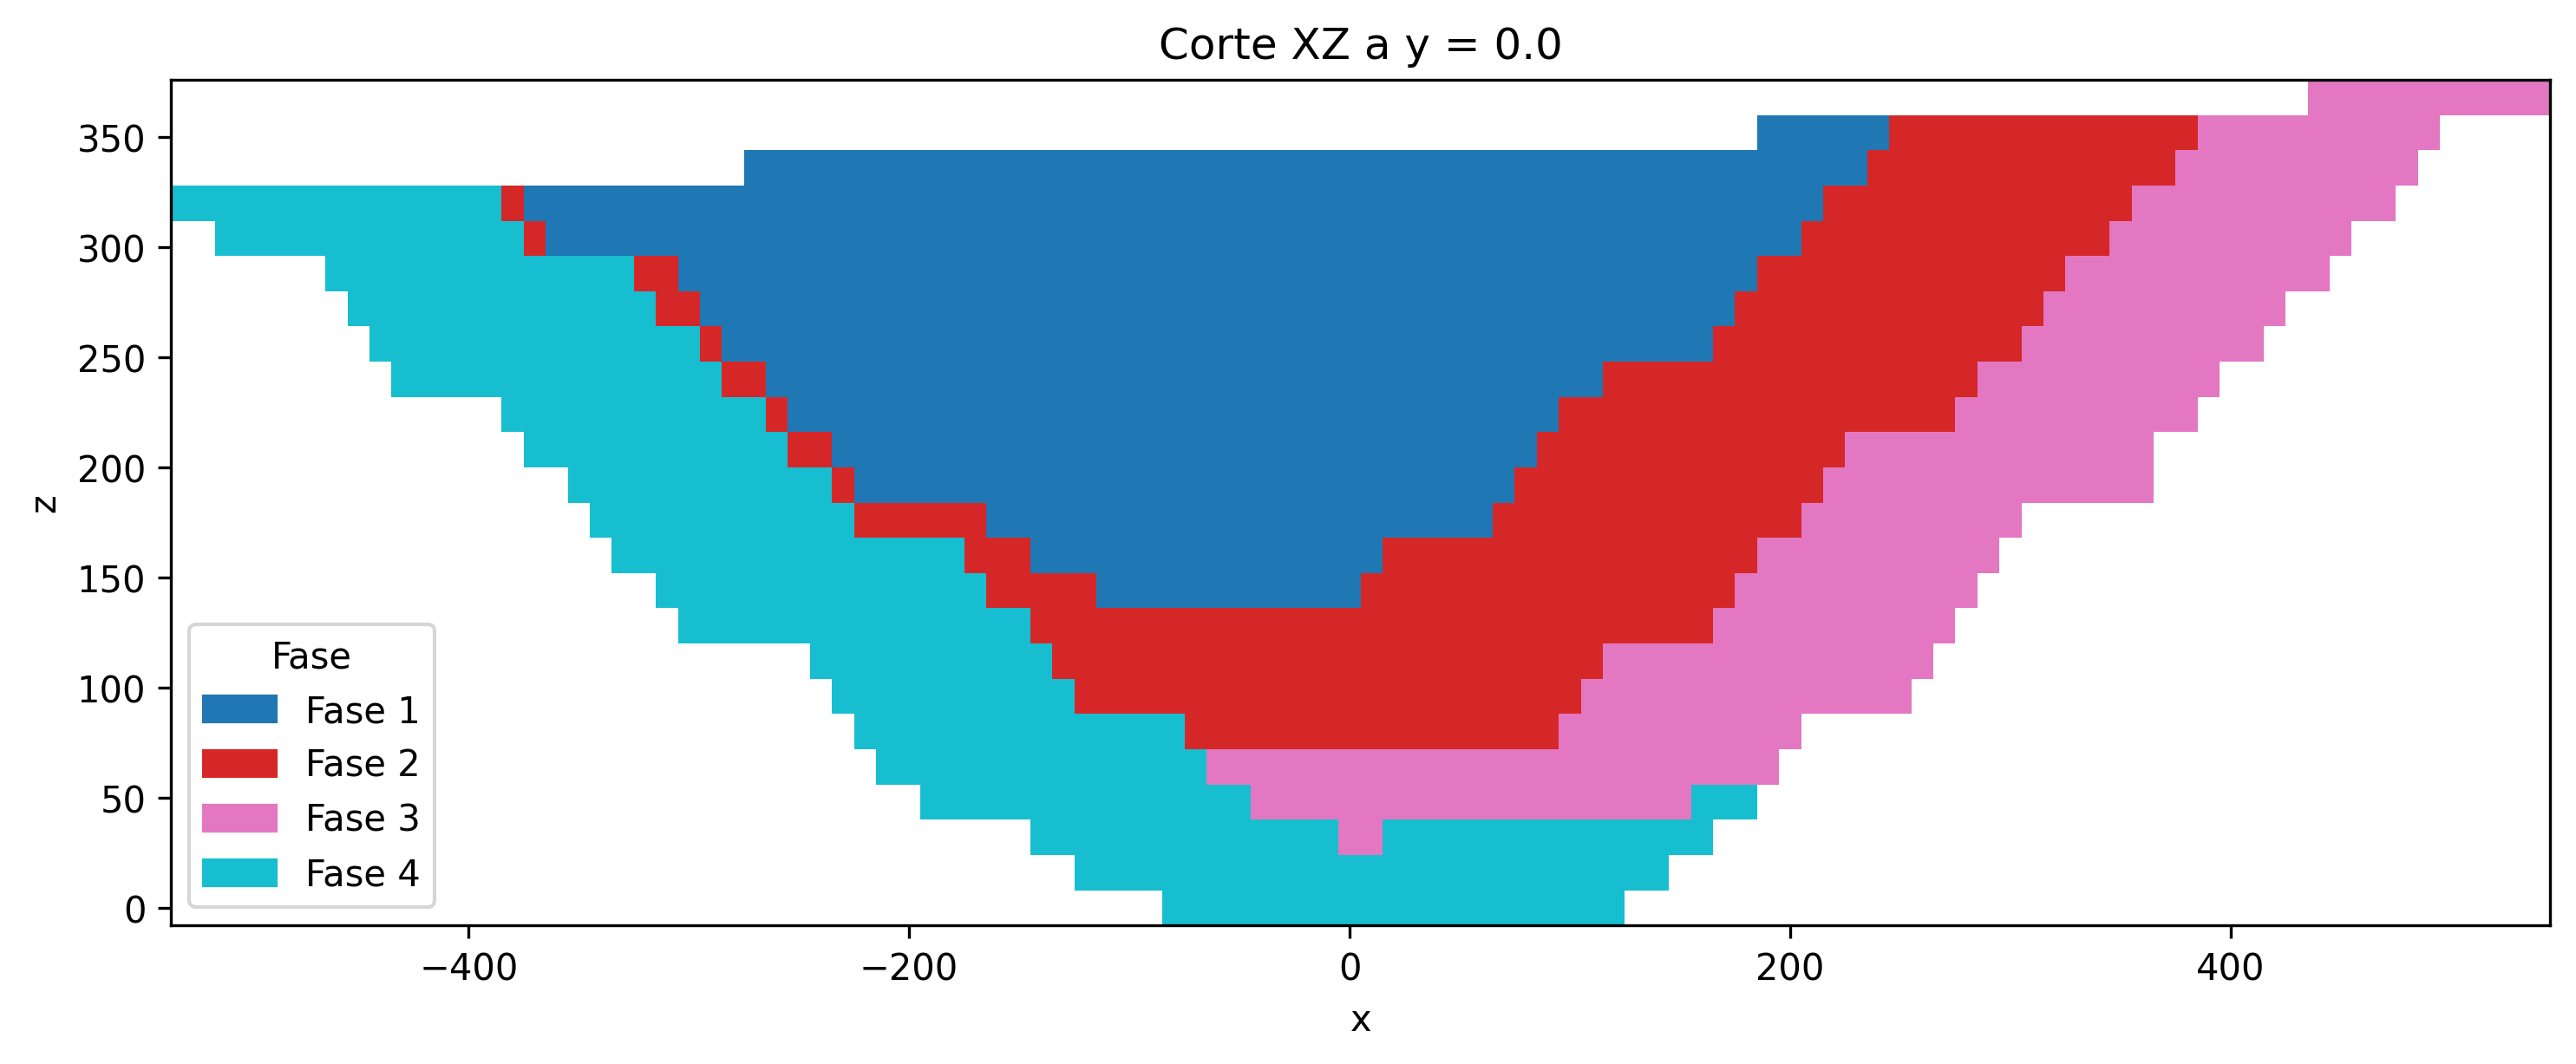

In [19]:
mina_plot = mina.copy()
mina_plot['x'] = mina_plot['x'] - mina_plot['x'].median()
mina_plot['y'] = mina_plot['y'] - mina_plot['y'].median()
mina_plot['z'] = mina_plot['z'] - mina_plot['z'].min()

plot_perfil_mina(mina_plot, eje='xz', cmap='tab10', valor_corte=mina_plot['y'].median())

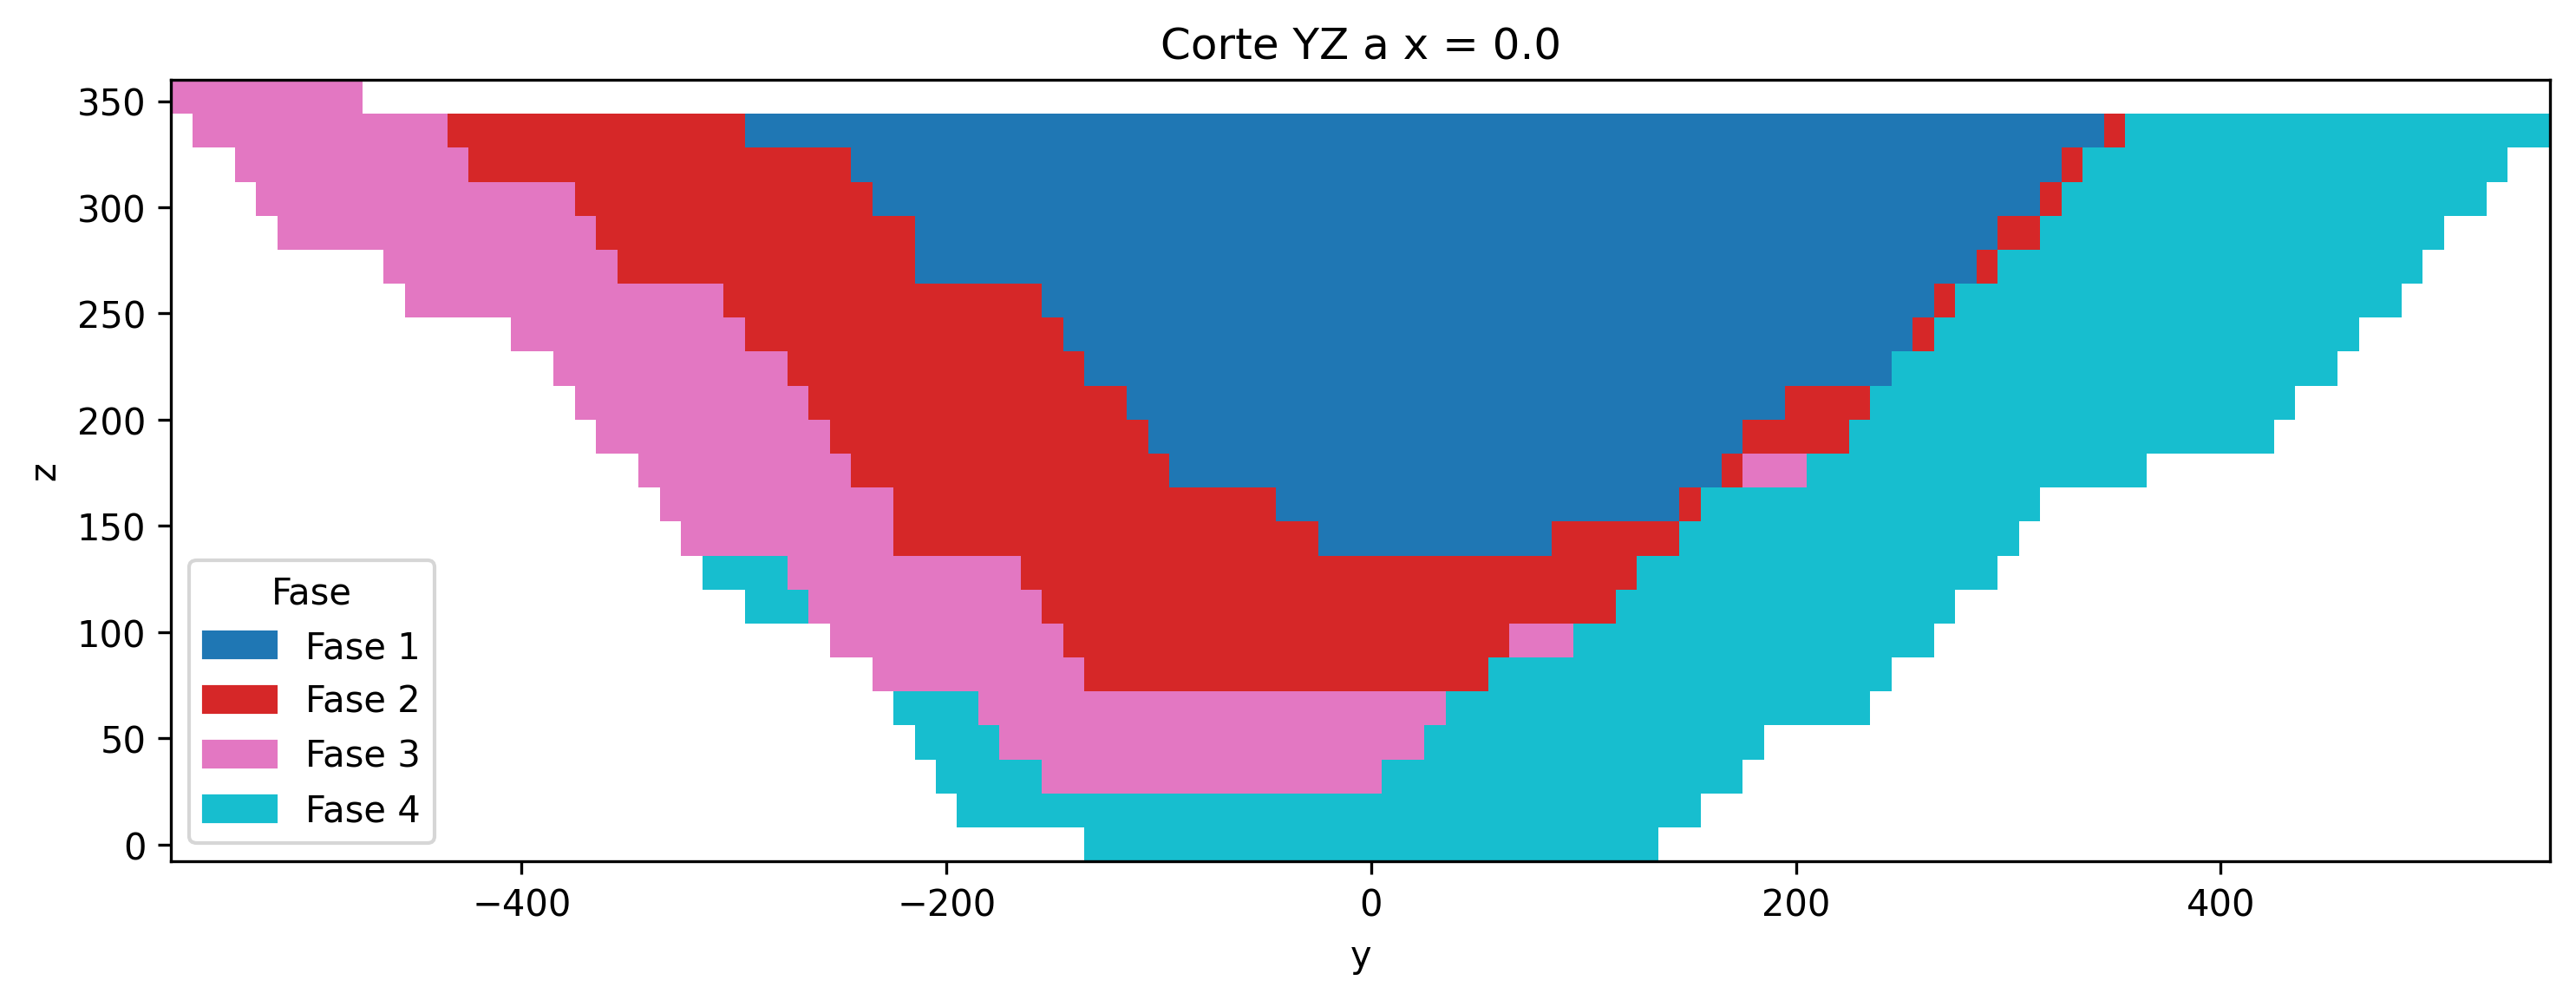

In [20]:
plot_perfil_mina(mina_plot, eje='yz', cmap='tab10', valor_corte=mina_plot['x'].median())

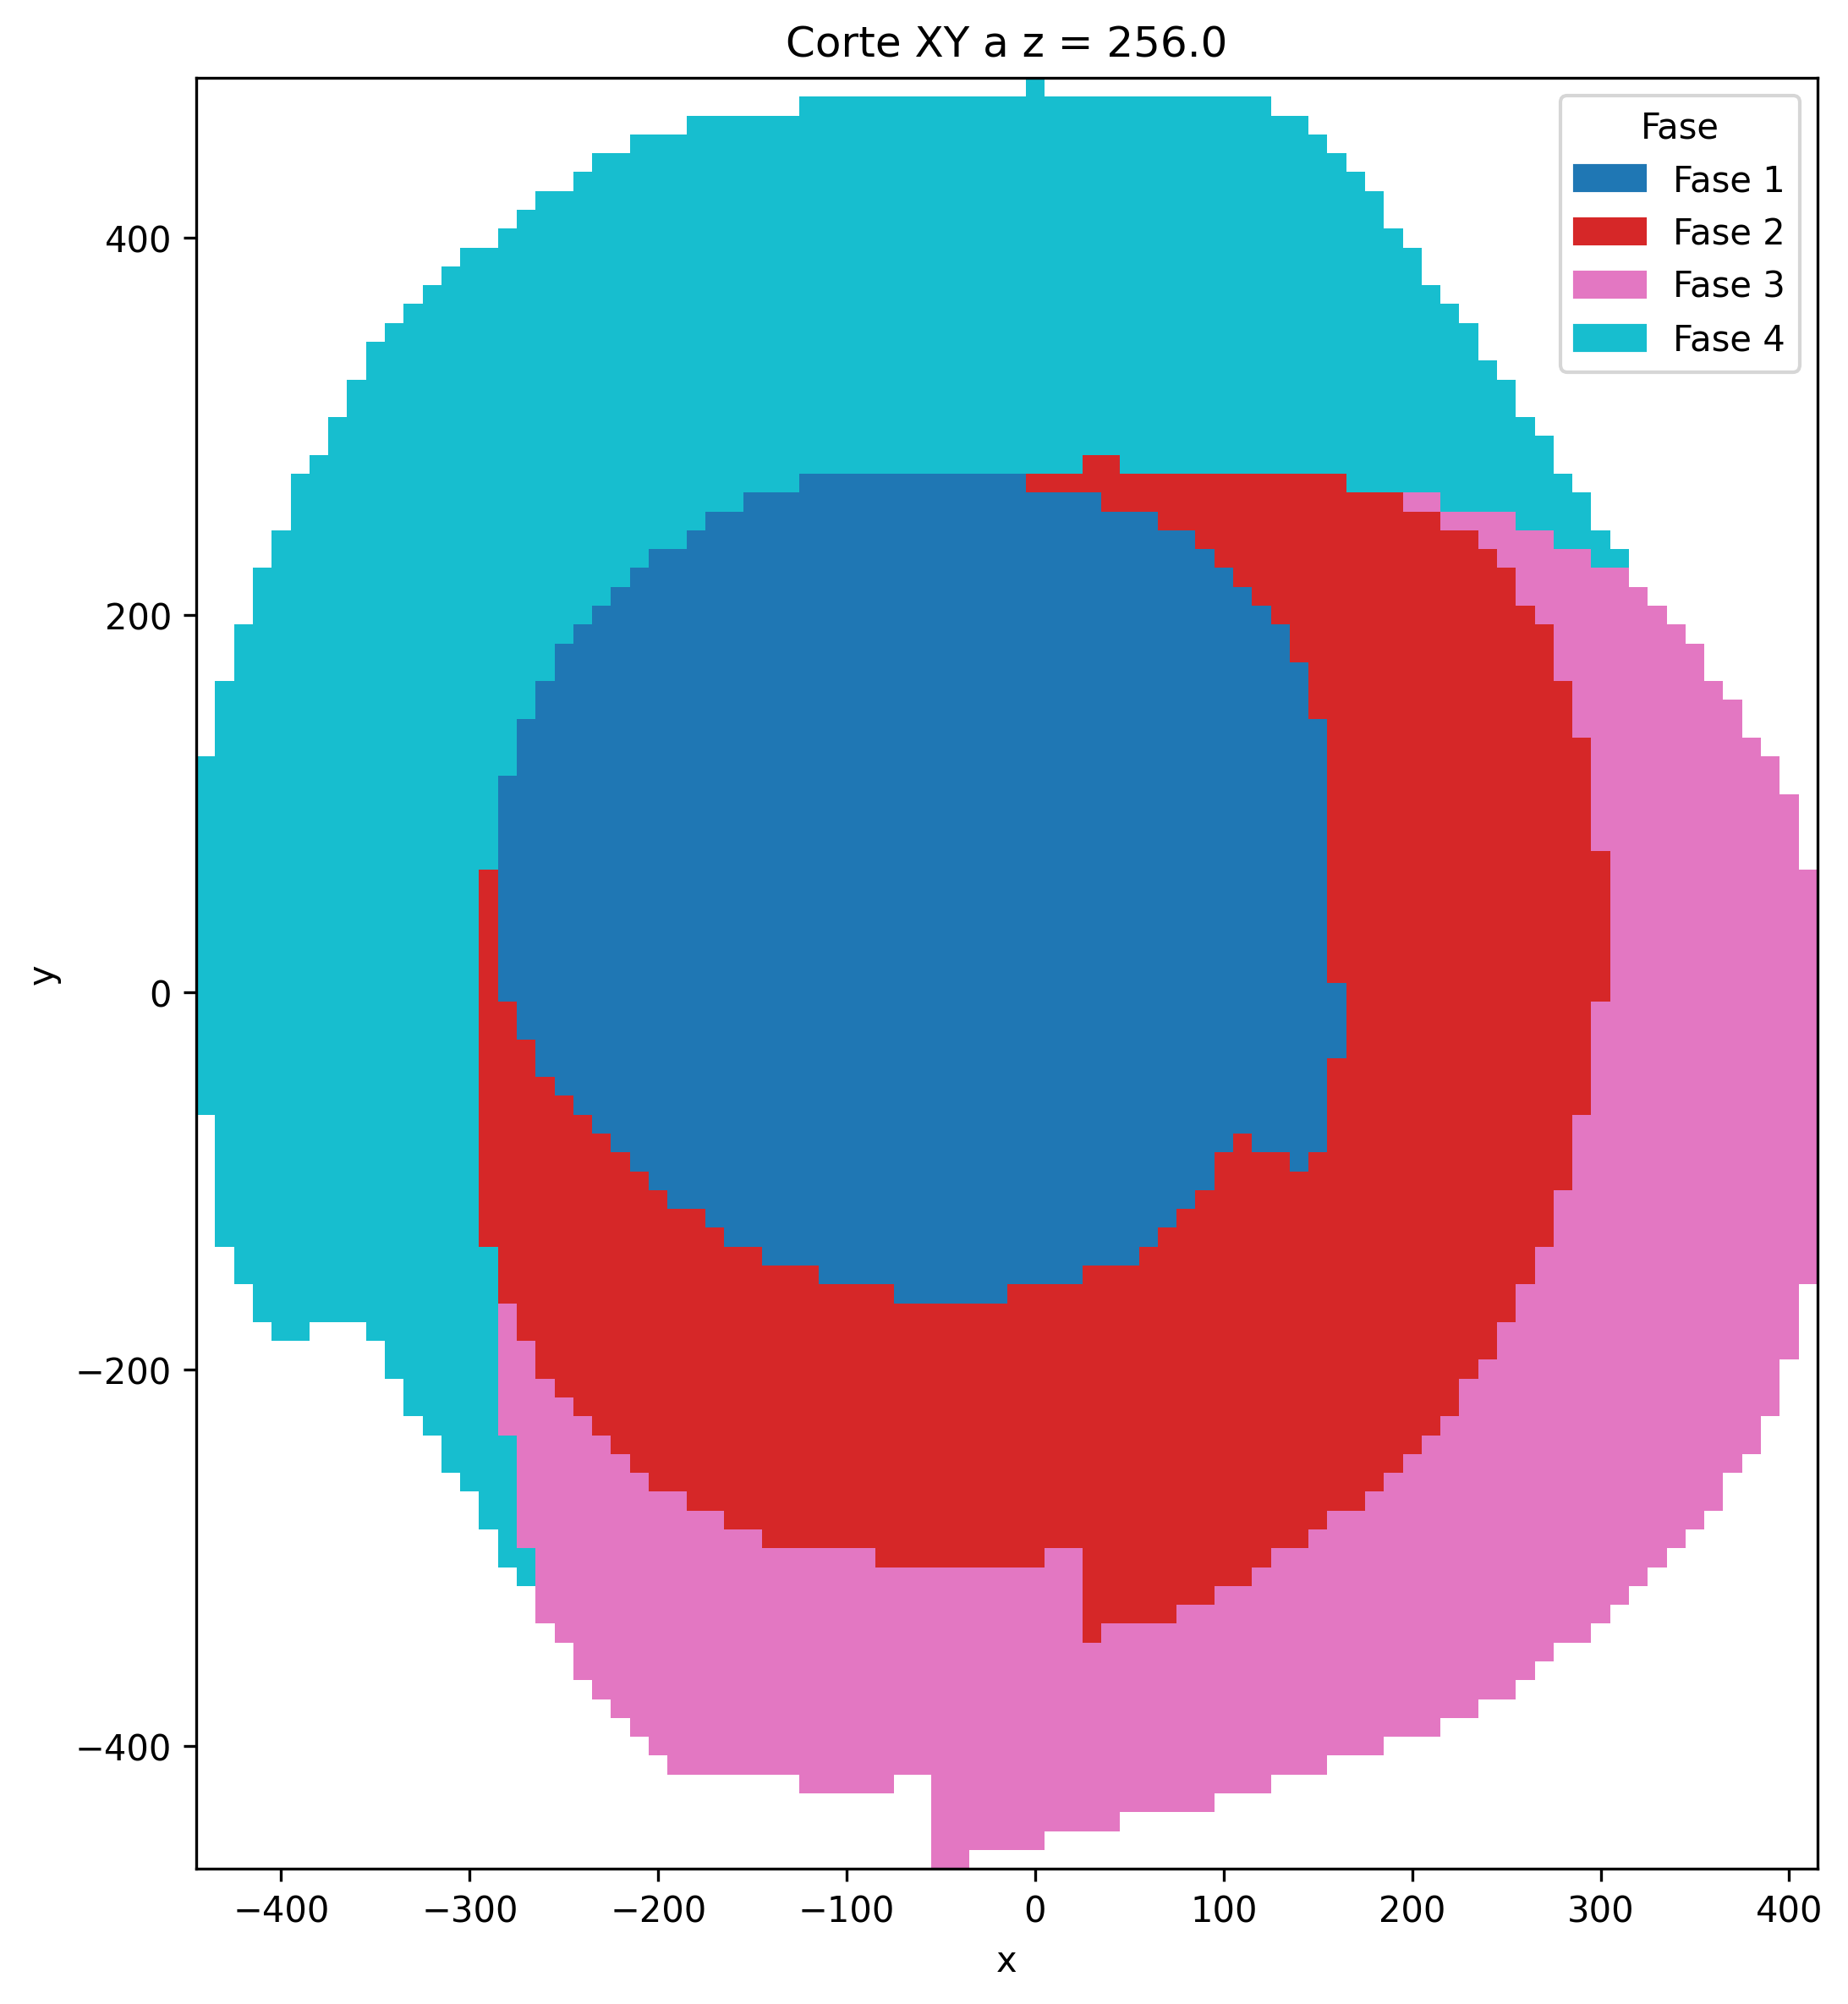

In [21]:
plot_perfil_mina(mina_plot, eje='xy', cmap='tab10', valor_corte=mina_plot['z'].median())